# 2A.ml - Machine Learning et données cryptées - correction

Comment faire du machine learning avec des données cryptées ? Ce notebook propose d'en montrer un principe exposés [CryptoNets: Applying Neural Networks to Encrypted Data with High Throughput and Accuracy](http://proceedings.mlr.press/v48/gilad-bachrach16.pdf). Correction.

In [1]:
%matplotlib inline

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

**Principe**

Voir l'énoncé.

## Exercice 1 : écrire deux fonctions de cryptage, décryptage

Il faut bien choisir $n$, $a$ pour implémenter la fonction de cryptage :
$\varepsilon:\mathbb{N} \rightarrow \mathbb{Z}/n\mathbb{Z}$ et $\varepsilon(x) = (x * a) \mod n$. On vérifie ensuite qu'elle conserve l'addition au module $n$ près.

In [4]:
def compose(x, a, n):
    return (a * x) % n

def crypt(x):
    return compose(x, 577, 10000)

crypt(5), crypt(6)

(2885, 3462)

In [6]:
crypt(5+6), (crypt(5) + crypt(6)) % 10000

(6347, 6347)

In [8]:
crypt(6-5), (crypt(6) - crypt(5)) % 10000

(577, 577)

In [10]:
crypt(5-6), (crypt(5) - crypt(6)) % 10000

(9423, 9423)

Si $a=47$, on cherche $a',k$ tel que $aa' - nk=1$.

In [12]:
n = 10000
for k in range(2, n):
    if (577*k) % n == 1:
        ap = k
        break
ap

2513

In [14]:
def decrypt(x):
    return compose(x, 2513, 10000)

decrypt(crypt(5)), decrypt(crypt(6))

(5, 6)

In [16]:
decrypt(crypt(5)*67), decrypt(crypt(5*67))

(335, 335)

## Notes sur l'inverse de a

Si $n$ est premier alors $\mathbb{Z}/n\mathbb{Z}$ est un corps. Cela implique que tout nombre $a \neq 0$ a un inverse dans $\mathbb{Z}/n\mathbb{Z}$. Donc, $\forall a \neq 0, \exists a'$ tel que $aa'=1$. On va d'abord montrer que $\forall a \neq 0, \forall k \in \mathbb{N^*}, a^k \neq 0$. On procède par l'absurde en supposant que $\exists k > 0$ tel quel $a^k=0$. Cela signifie qu'il existe $v$ tel quel $a^k = vn$. Comme $n$ est premier, $a$ divise $v$ et on peut écrire que $a^k = wan \Rightarrow a(a^{k-1} - wn)=0$. Par récurrence, on peut montrer qu'il existe $z$ tel que $a = zn$ donc $a$ est un multiple de $n$ et c'est impossible car $a$ et $n$ sont premiers entre eux.

L'ensemble $A=\{a, a^2, a^3, ...\}$ est à valeur dans $\mathbb{Z}/n\mathbb{Z}$ et est fini donc il existe nécessairement $i$ tel que $a^i \in A$. Il existe alors $k > 0$ tel que $a^i \equiv a^k \mod n$ et $u$ tel que $a^i = a^k + un$. On suppose d'abord que $i > k$, alors $a^k(a^{i-k} -1) = un$. Comme $n$ est premier, $a^{i-k} -1$ divise $n$ donc il existe $v$ tel que $a^{i-k}=un + 1$ donc $a^{i-k} \equiv 1 \mod n$. On note $a^{i-k-1} = a^{-1}$ l'inverse de $a$ dans $\mathbb{Z}/n\mathbb{Z}$. Si $k > i$, la même chose est vraie pour $a^{k-i}$. Si $i^*=\arg\min\{i \, | \, a^i \in A\}$, $i^* \leqslant n-1$ car l'ensemble $A$ contient au plus $n-1$ éléments et $i^*-k < n-1$. On note maintenant $j^* = \arg \min \{j \, | \, a^j \equiv 1 \mod n\}$. Donc ce cas, on peut montrer que $A = \{1, a, ..., a^{j^*-1}\}$.

On s'intéresse maintenant à $b=a^k \in A$ avec $k > 1$. Si $k$ divise $j^*$ alors $A_k=B=\{1, a^k, a^{2k}, ..., a^{j^*-1}\}= \{1, b, b^2, ..., b^{\frac{j^*}{k}-1}\}$. Donc pour toutes les puissances de $a^k$, le nombre d'éléments de $A_k$ est un diviseur du nombre d'éléments de $A$. Supposons qu'il existe un élément $a$ tel que le nombre maximum d'éléments de $A$ est $n-1$, c'est-à-dire qu'il contient tous les éléments non nuls de $\mathbb{Z}/n\mathbb{Z}$. Alors tous les groupes $A_k$ ont un nombre d'éléments qui divise $n-1$. Donc si $\mathbb{Z}/n\mathbb{Z}$ possède un élément $a$ tel que l'ensemble $A$ a $n-1$ éléments, alors tous les ensembles $B=\{1, b, b^2, b^3, ...\}$ ont un nombre d'éléments qui divise $n-1$. Cela signifie aussi que $a^{n-1} \equiv 1 \mod n$ pour tous les éléments de $\mathbb{Z}/n\mathbb{Z}$ (voir [théorème de Lagrange](https://fr.wikipedia.org/wiki/Th%C3%A9or%C3%A8me_de_Lagrange_sur_les_groupes)).

Si pour tous les éléments de $\mathbb{Z}/n\mathbb{Z}$, il n'existe aucun ensemble $B=\{1, b, b^2, b^3, ...\}$ avec $n-1$ éléments, cela signifie que $\forall a\neq 0 \in \mathbb{Z}/n\mathbb{Z}, \exists i < n-1, a^i \equiv 1 \mod n$. On note $i(a)$ la puissance minimale à laquelle $a^{i(a)}\equiv 1 \mod n$. Si on peut trouver $a$ et $b$ tels que $i(a) \neq i(b)$, alors $i(ab)=PGCM(i(a), i(b))$. C'est le plus grand multiple commun de $i(a)$ et $i(b)$ et celui-ci est nécessairement inférieur ou égal à $n-1$. Il reste à montrer que $p=PGCM\left(i(a) \, | \, a \in \mathbb{Z}/n\mathbb{Z}\right)=n-1$ ou tout du moins un diviseur. Il ne peut pas être plus grand.

*à suivre*

## Exercice 2 : Entraîner une régression linéaire

In [18]:
from sklearn.datasets import load_diabetes
data = load_diabetes()

In [19]:
X = data.data
Y = data.target

In [20]:
from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [22]:
clr.predict(X[:1]), Y[0]

(array([ 206.11706979]), 151.0)

In [24]:
from sklearn.metrics import r2_score
r2_score(Y, clr.predict(X))

0.51774942541329338

On considère seulement la fonction de décision brute car c'est une fonction qui peut-être calculée à partir d'additions et de multiplications. Pour la suite, nous aurons besoin d'un modèle qui fonctionne sur des variables normalisées avec [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). On supprime également le biais pour le remplacer par une colonne constante.

In [26]:
from sklearn.preprocessing import MinMaxScaler
import numpy
X_norm = numpy.hstack([MinMaxScaler((0, 100)).fit_transform(X), 
                       numpy.ones((X.shape[0], 1))])
Y_norm = MinMaxScaler((0, 100)).fit_transform(Y.reshape(len(Y), 1)).ravel()

In [27]:
Y_norm.min(), Y_norm.max()

(0.0, 100.0)

In [29]:
clr_norm = LinearRegression(fit_intercept=False)
clr_norm.fit(X_norm, Y_norm)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [31]:
clr_norm.predict(X_norm[:1]), Y_norm[0]

(array([ 56.42276317]), 39.252336448598129)

In [33]:
from sklearn.metrics import r2_score
r2_score(Y_norm, clr_norm.predict(X_norm))

0.51774942541329338

## Exercice 3 : réécrire la fonction de prédiction pour une régression linéaire

La fonction est un produit scalaire.

In [35]:
def decision_linreg(xs, coef, bias):
    s = bias
    xs = xs.copy().ravel()
    coef = coef.copy().ravel()
    if xs.shape != coef.shape:
        raise ValueError("Not the same dimension {0}!={1}".format(xs.shape, coef.shape))
    for x, c in zip(xs, coef):
        s += c * x
    return s

In [36]:
list(X[0])[:5]

[0.038075906433424102,
 0.050680118739818703,
 0.061696206518688498,
 0.021872354994955798,
 -0.044223498424446402]

In [38]:
clr.predict(X[:1]), decision_linreg(X[:1], clr.coef_, clr.intercept_)

(array([ 206.11706979]), 206.1170697870923)

In [40]:
clr_norm.predict(X_norm[:1]), decision_linreg(X_norm[:1], clr_norm.coef_, clr_norm.intercept_)

(array([ 56.42276317]), 56.422763173548944)

## Exercice 4 : assembler le tout

Prendre une observation, crypter, prédire, décrypter, comparer avec la version non cryptée. Il faudra sans doute un peu ruser car la fonction de cryptage s'applique à des entiers et le modèle de prédiction à des réels. On multiplie par 10000 les variables. Comme le cryptage que nous avons choisi ne conserve que l'addition, nous garderons les modèles en clair.

In [42]:
coef_int = [int(i) for i in clr_norm.coef_ * 100]
coef_int

[0, -7, 42, 24, -69, 46, 8, 14, 60, 5, -843]

In [44]:
inter_int = int(clr_norm.intercept_ * 10000)
inter_int

0

In [46]:
import numpy


def decision_linreg_int(xs, coef):
    s = 0
    for x, c in zip(xs, coef):
        s += c * x
    return s % 10000

def decision_crypt_decrypt_linreg(xs, coef_int):
    # On crypte les entrées
    int_xs = [int(x) for x in xs.ravel()]
    crypt_xs = [crypt(i) for i in int_xs]
    # On applique la prédiction.
    pred = decision_linreg_int(crypt_xs, coef_int)
    # On décrypte.
    dec = decrypt(pred % 10000)
    return dec / 100

(decision_linreg(X_norm[:1], clr_norm.coef_, clr_norm.intercept_), 
 decision_crypt_decrypt_linreg(X_norm[0], coef_int))

(56.422763173548944, 54.65)

0 56.4227631735 54.65
1 13.4181768255 11.59
2 47.3159066512 45.73
3 44.2112042336 42.02
4 32.2304805013 30.26


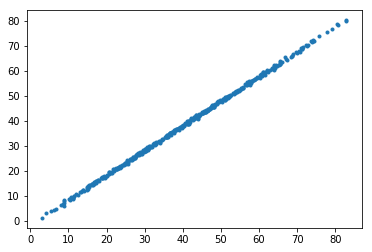

In [48]:
p1s = []
p2s = []
for i in range(0, X_norm.shape[0]):
    p1 = decision_linreg(X_norm[i:i+1], clr_norm.coef_, clr_norm.intercept_)
    p2 = decision_crypt_decrypt_linreg(X_norm[i], coef_int)
    if i < 5:
        print(i, p1, p2)
    p1s.append(p1)
    p2s.append(p2)

import matplotlib.pyplot as plt
plt.plot(p1s, p2s, '.')

**Notes**

Les coefficients sont en clair mais les données sont cryptées. Pour crypter les coefficients du modèle, il faudrait pouvoir s'assurer que l'addition et la multiplication sont stables après le cryptage. Cela nécessite un cryptage différent comme [Fully Homomorphic Encryption over the Integers](https://eprint.iacr.org/2009/616.pdf). Les entiers cryptés sont dans l'intervalle [0, 10000], cela veut dire qu'il est préférable de crypter des entiers dans un intervalle équivalent sous peine de ne pouvoir décrypter avec certitude. Ceci implique que l'algorithme fasse des calculs qui restent dans cet intervalle. C'est pourquoi les entrées et les sorties prennent leur valeur dans l'intervalle [0, 100] afin que le produit *coefficient x entrée* reste dans l'intervalle considéré. Pour éviter ce problème, il faudrait décomposer chaque entier en une séquence d'entiers entre 0 et 100 et réécrire les opérations addition et multiplication en fonction.

## Questions

Le cryptage choisi est moins efficace qu'un cryptage [RSA](https://fr.wikipedia.org/wiki/Chiffrement_RSA) qui conserve la multiplication. Il faudrait transformer l'écriture du modèle pour utiliser des multiplications plutôt que des additions. Si je vous disais qu'une des variables est l'âge d'une population, vous pourriez la retrouver. Il en est de même pour un chiffrage RSA qui change un entier en un autre. On peut crypter des éléments de ces entiers et les recomposer dans le monde crypté. C'est ce que propose d'autres type de cryptage. **On peut aussi altérer les données en ajoutant un bruit aléatoire qui change peu la prédiction mais qui change la valeur cryptée. Dans ce cas, la distribution de chaque variable paraîtra uniforme.**

On peut entraîner un modèle sur des données cryptées si on peut reproduire l'addition et la multiplication avec les nombres cryptés. Une option est le cryptage : [Fully Homomorphic Encryption over the Integers](https://eprint.iacr.org/2009/616.pdf). Cela implique qu'on peut approcher toute fonction par un polynôme (voir [développement limité](https://fr.wikipedia.org/wiki/D%C3%A9veloppement_limit%C3%A9)). Le gradient d'un polynôme est un polynôme également. Il est possible de calculer la norme du gradient crypté mais pas de la comparer à une autre valeur cryptées.

De ce fait les arbres de décision se prêtent mal à ce type d'apprentissage puisque chaque noeud de l'arbre consiste à comparer deux valeurs. Cependant, on peut s'en sortir en imposant à l'algorithme d'apprentissage d'un arbre de décision de ne s'appuyer sur des égalités. Cela nécessite plus de coefficients et la discrétisation des variables continues. Il reste une dernière chose à vérifier. Chaque noeud d'un arbre de décision est déterminé en maximisant une quantité. Comment trouver le maximum dans un ensemble de données cryptées qu'on ne peut comparer ? On utilise une propriété des normes :

$$\lim_{d \rightarrow \infty} (x^d + y^d)^{1/d} = \max(x, y)$$

Il existe d'autres options : [Machine Learning Classification over Encrypted Data](https://eprint.iacr.org/2014/331.pdf).

## Ajouter du bruit sur une colonne

Les données peuvent être cryptées mais la distribution est inchangée à une permutation près. Pour éviter cela, on ajoute un peu de bruit, nous allons voir comment faire cela. On suppose que nous avons une colonne qui des entiers distribués selon une loi de Poisson.

In [50]:
from numpy.random import poisson
X = poisson(size=10000)
mx = X.max()+1
X.min(), mx

(0, 8)

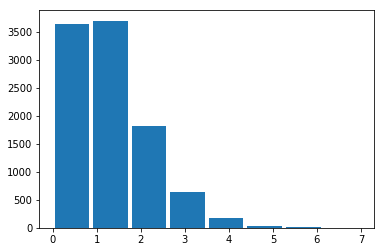

In [52]:
from matplotlib import pyplot as plt
plt.hist(X, bins=mx, rwidth=0.9);

In [53]:
def crypt(x):
    return compose(x, 5794, 10000)

In [54]:
import numpy
Xcrypt = numpy.array([crypt(x) for x in X])

In [55]:
Xcrypt[:10]

array([   0, 5794, 5794, 5794, 5794,    0, 7382, 7382,    0, 1588])

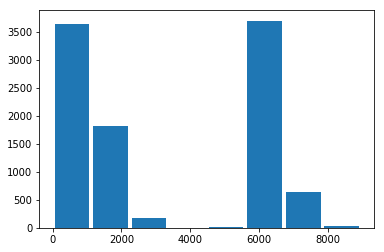

In [57]:
plt.hist(Xcrypt, bins=mx, rwidth=0.9);

Même distribution dans un ordre différent. Pour changer cette distribution, on ajoute un petit bruit peu important pour la variable numérique considérée mais qui sera cryptée de manière totalement différente.

In [58]:
import random
Xbruit = numpy.array([100*x + random.randint(0,100) for x in X])
Xbruit[:10]

array([ 90, 145, 120, 172, 131,  76, 343, 398,  17, 288])

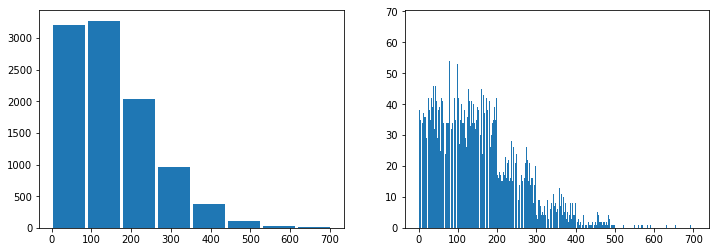

In [60]:
fix, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(Xbruit, bins=mx, rwidth=0.9)
ax[1].hist(Xbruit, bins=mx*100);

In [61]:
Xbruitcrypt = numpy.array([crypt(x) for x in Xbruit])

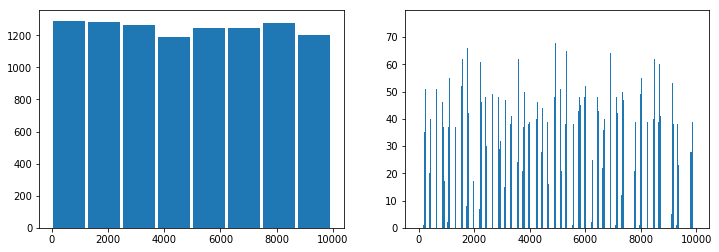

In [62]:
fix, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(Xbruitcrypt, bins=mx, rwidth=0.9)
ax[1].hist(Xbruitcrypt, bins=mx*100);

Le bruit ajouté ne change rien, la nouvelle variable permet de discriminer aussi bien mais il multiplie le nombre de valeurs distinctes. Si chaque valeur est presque unique, l'histogramme de la variable cryptée est quasi-uniforme.